In [1]:
# using Pkg
# Pkg.generate("model0")

In [2]:
# Pkg.add("OrdinaryDiffEq")
# Pkg.add("DifferentialEquations")
# Pkg.add("ModelingToolkit")
# Pkg.add("DataDrivenDiffEq")
# Pkg.add("LinearAlgebra")
# Pkg.add("DiffEqSensitivity")
# Pkg.add("Optim")
# Pkg.add("DiffEqFlux")
# Pkg.add("Flux")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("GLM")
# Pkg.add("StatsModels")
# Pkg.add("CSV")
# Pkg.add("Interpolations")
# Pkg.add("JLD2")
# Pkg.add("Suppressor")
# Pkg.add("Distributed")
# Pkg.add("ParallelDataTransfer")
# Pkg.add("LaTeXStrings")
# Pkg.add("Statistics")
# Pkg.add("StatsBase")
# Pkg.add("Plots")

In [3]:
println(@__DIR__)
using Pkg
Pkg.activate(string(@__DIR__, "/model0/Project.toml"))
Pkg.status()

/home/ziyu/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload


 Activating environment at `~/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload/model0/Project.toml`


Project model0 v0.1.0
Status `~/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload/model0/Project.toml`
  [91a5bcdd] Plots v1.6.12


In [4]:
# cd(@__DIR__)
# using Pkg; Pkg.activate("."); Pkg.instantiate()
using OrdinaryDiffEq, DifferentialEquations
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
using DataFrames, GLM, StatsModels
using CSV
using Interpolations
using JLD2
using Suppressor
using Distributed
using ParallelDataTransfer
using LaTeXStrings, Statistics
using StatsBase
using Plots
gr()

Plots.GRBackend()

# Data cleaning and preparation

Getting parameters that ease initialisation. These parameters were generated using the Nelder Mead method. Using other methods to generate parameters can work as well but may significantly increase the time taken for Model 0 to run. 

In [5]:
println(@__DIR__)

country = "Botswana"
paras = CSV.read(string(@__DIR__, "/model0_initialisation/",country,"_initialisation.csv"),
    normalizenames = true, 
    DataFrame)

nnp = Array(paras[!,country]) #α,δ,gᵦ,gₐ

/home/ziyu/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload


4-element Array{Float64,1}:
  0.02680426502431278
 -0.045027129714276595
  0.04616730802149254
 -0.035365190287845974

Getting time series data for Botswana, and cleaning the data

In [6]:
function getCleandataFrame(country)
    df_year=df[!,"Year"][2:end]
    df1=df[!,string(country,"_yt")]  #GDP
    df2=df[!,string(country,"_kt")] #capital per capita
    df3=df[!,string(country,"_srate")][2:end] # savig rate
    df6= df[!,string(country,"_et")] #population
    df4= df[!,string(country,"_nt")][2:end] #population
    df8=df6[1:end-1] .-df6[2:end]#de
    df6=df6[2:end]
    df5=df2[1:end-1] .-df2[2:end] #dk
    df2=df2[2:end]
    df7= df1[1:end-1] .-df1[2:end] # dydt
    df1=df1[2:end]
    newdf= DataFrame(Year=df_year,yt=df1, k=df2, srate=df3,nt=df4,dkdt=df5,dydt=df7,dedt=df8,et=df6)
    newdf=newdf[completecases(newdf), :]
    return newdf, df8, df5, df7
end


getCleandataFrame (generic function with 1 method)

In [7]:
df = CSV.read(string(@__DIR__, "/compileddf.csv"),
    normalizenames = true, 
    DataFrame)

newdf, df8, df5, df7=getCleandataFrame(country)
years_available=size(newdf)[1]


st = interpolate(newdf[!,"srate"], BSpline(Quadratic(Free(OnCell()))))
nt = interpolate(newdf[!,"nt"], BSpline(Quadratic(Free(OnCell()))))

kdata= newdf[!,"k"]
ydata=newdf[!,"yt"]
edata=newdf[!,"et"]
kic= newdf[!,"k"][1]
yic=newdf[!,"yt"][1]
eic=newdf[!,"et"][1]

newdf

,Year,yt,k,srate,nt,dkdt,dydt,dedt
,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,1975,0.001223,0.00408493,0.202551,0.0488591,-0.000141476,7.7e-5,-0.129126
2,1976,0.001381,0.00404858,0.216694,0.0520614,3.63524e-5,-0.000158,-0.519256
3,1977,0.001358,0.00402169,0.222357,0.0542297,2.68853e-5,2.3e-5,-0.204174
4,1978,0.001537,0.00407305,0.227837,0.0521772,-5.13577e-5,-0.000179,-0.0242368
5,1979,0.001613,0.00424262,0.298039,0.0490789,-0.00016957,-7.6e-5,-0.0894769
6,1980,0.001765,0.00457454,0.286999,0.0439067,-0.000331921,-0.000152,-0.00922081
7,1981,0.001858,0.00477105,0.278738,0.0377156,-0.000196508,-9.3e-5,0.0147756
8,1982,0.001921,0.00494978,0.266413,0.0387538,-0.000178735,-6.3e-5,-0.0586634
9,1983,0.002144,0.00482787,0.29919,0.0374656,0.000121908,-0.000223,0.108086


Alternatively, this is the code used to generate the parameters using the Nelder Mead method. We assume that the equations in the Green Solow model are not coupled here, to ease the search for parameters. This finds feasible values of the parameters, in a very large search space. Later, when doing a non-linear regression, we constrain the regression to use consistent parameters. 

In [8]:
# solving equation for k using optimiser and mse loss

function solowK(α,θ)
  
income = kdata .^ (α-1) .* (1 - θ) 
   return income
end

function loss(x)
    α = x[1]
    θ = x[2]
    pred= solowK(α,θ)
    return Flux.mse(ydata, pred)
end

res = optimize(loss, [0.0,0.0]) #the initialisation values can significantly affect the outcome parameter values
a,b = Optim.minimizer(res) #alpha and theta

2-element Array{Float64,1}:
 1.4416024211450507
 0.9772848764527233

In [9]:
# solving equation for dk/dt using optimiser and mse loss

dk = kdata[1:end-1] .-  kdata[2:end]

function soloweqn1alt(δg)
    dk = st .* ydata .- (δg .+ nt) .* kdata # rate of change of kt, δg is delta+gB
end

function losseqn1(δg)
    pred= soloweqn1alt(δg)
    return Flux.mse(dk, pred[2:end])
end

reseqn = optimize(losseqn1, -200.0, 200.0)
δg = Optim.minimizer(reseqn)
# Optim.minimum(reseqn)

0.14604633278599266

In [10]:
# solving equation for dy/dt using optimiser and mse loss

dy = ydata[1:end-1] .-  ydata[2:end]
α = a
function soloweqn2alt(gᵦ)
    dy = ydata[2:end] .* (gᵦ .+ α .* dk ./ kdata[2:end]) # rate of change of yt 
end

function losseqn2(x)
    gᵦ = x
    pred= soloweqn2alt(gᵦ)
    return Flux.mse(dy, pred)
end

reseqn2 = optimize(losseqn2, -200.0, 200.0)
gᵦ = Optim.minimizer(reseqn2)
display(Optim.minimum(reseqn2))
display(gᵦ)
# δ = δg - gᵦ

3.5594089661813926e-8

0.08627203228272862

In [11]:
# solving equation for de/dt using optimiser and mse loss

de = edata[1:end-1] .-  edata[2:end]
function soloweqn3alt(gₐ)
    de = edata[2:end] .* (-gₐ .+ dy ./ ydata[2:end])
end

function losseqn3(gₐ)
    pred= soloweqn3alt(gₐ)
    return Flux.mse(de, pred)
end

reseqn3 = optimize(losseqn3, -200.0, 200.0)
gₐ = Optim.minimizer(reseqn3)
display(Optim.minimum(reseqn3))
display(gₐ)

0.0480429997164114

0.00798208315199172

# Finding the optimal parameters in the coupled system

Using the parameters to solve the ODEs as a coupled system. 

The ODEs are solved using TRBDF2 because the problem is stiff. The solver is robust to oscillations and massive stiffness. 

In [12]:
function solownneqn1(du,u,p,t)
    sₜ = st(t) #savings rate
    nₜ = nt(t)

    k = u[1]
    y=u[2]
    e=u[3]
    α,δ,gᵦ,gₐ= p
    du[1] = sₜ*y-(δ+nₜ+gᵦ)*k # rate of change of kt
    du[2] = y*(gᵦ+α*du[1]/k) # rate of change of yt
    du[3] = e*(-gₐ+du[2]/y)
    return du
end

nntspan = (1.0e0,years_available*1.0) 
nndatasize = years_available
nntsteps = range(nntspan[1], nntspan[2], length=nndatasize)
u0 = Float32[kic,yic,eic] ## kt initial
prob_solownneqn = ODEProblem(solownneqn1, u0, nntspan, nnp)
pred = solve(prob_solownneqn, TRBDF2(),p=nnp, abstol=1e-4, reltol=1e-4, saveat = nntsteps)

println("current losses: ")
kmse = Flux.mse(pred[1,:],kdata)
println(kmse)
ymse = Flux.mse(pred[2,:],ydata)
println(ymse)
emse = Flux.mse(pred[3,:],edata)
println(emse)

current losses: 
4.6020879827982805e-6
2.2111427723147767e-7
0.5255843946271717


In [13]:
function predicts(θ)
    Array(solve(prob_solownneqn,TRBDF2(),p=θ, abstol=1e-4, reltol=1e-4, saveat = nntsteps))
end

losses=[]

    
function loss(θ)
    pred = predicts(θ)
    kloss=sum(abs,(pred[1,:].-kdata))./ sum(pred[1,:].+ kdata)
    yloss=sum(abs, (pred[2,:].-ydata))./sum(pred[2,:].+ydata)
    eloss=sum(abs,(pred[3,:].-edata))./sum(pred[3,:].+edata)
    return ((kloss+eloss+yloss)), pred
end
          
callback(θ,l,pred) = begin
        push!(losses, l)
        false
end

res1= DiffEqFlux.sciml_train(loss, nnp, ADAM(0.001),cb=callback, maxiters=100)
println(losses[end-1])
res1= DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)
println(losses)


while ((mean(losses[end-100:end-50])>=(1.001*mean(losses[end-49:end]))) || std(losses[end-49:end]) >=0.001) && length(losses) <3000
    print("calculating res1")
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.0001),cb=callback, maxiters=200)
    try
        res1= DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)

    catch e
        print("Problematics")
        res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.0001),cb=callback, maxiters=100)
    end
    
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.00001),cb=callback, maxiters=100)

    try
        res1= DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)
    catch e
        res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.00001),cb=callback, maxiters=100)
        print("Problematics")
    end

end

pred = solve(prob_solownneqn, TRBDF2(),p=res1.minimizer, abstol=1e-4, reltol=1e-4, saveat = nntsteps)
println("current losses after training: ")
kmse = Flux.mse(pred[1,:],kdata)
println(kmse)
ymse = Flux.mse(pred[2,:],ydata)
println(ymse)
emse = Flux.mse(pred[3,:],edata)
println(emse)

res1.minimizer

best_model = pred

loss: 0.324: 100%|██████████████████████████████████████| Time: 0:00:02


0.32389709020649704
Any[0.32413304266489534, 0.32693290938870384, 0.3249873186387541, 0.32472384988989683, 0.3247674530678024, 0.32490210004529657, 0.32568940852777883, 0.3258449262610355, 0.326257177492698, 0.3261690820578054, 0.3257398718391457, 0.32568020357210364, 0.32565305437886, 0.3256814943649035, 0.32569161412787295, 0.3256150117460426, 0.3255876272293744, 0.3255676220642682, 0.3253045566348165, 0.32518289054333815, 0.32506208837544204, 0.3250194336770282, 0.32506940015983726, 0.32510995731692144, 0.325155196401617, 0.3250378323605306, 0.32493267846161744, 0.32487387796546424, 0.32490827543863565, 0.32496598734530685, 0.32512518712489535, 0.32532735396126544, 0.32531327920469383, 0.3252861761040263, 0.3253171708925549, 0.325321742901193, 0.3252489416494345, 0.3252465167846834, 0.32533757611357533, 0.3253236640611369, 0.3252945695141842, 0.32525173038103133, 0.3252733144266757, 0.32525868219074233, 0.3250930350611751, 0.3250234000498185, 0.32498490928899115, 0.3250001988800446,

loss: 0.323: 100%|██████████████████████████████████████| Time: 0:00:02
loss: 0.322: 100%|██████████████████████████████████████| Time: 0:00:01


current losses after training: 
4.47216673935207e-6
2.2093715188566083e-7
0.5250770381519745


retcode: Success
Interpolation: 1st order linear
t: 34-element Array{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
 13.0
  ⋮
 23.0
 24.0
 25.0
 26.0
 27.0
 28.0
 29.0
 30.0
 31.0
 32.0
 33.0
 34.0
u: 34-element Array{Array{Float32,1},1}:
 [0.0040849275, 0.001223, 0.25226375]
 [0.0041375165, 0.0012847272, 0.2745273]
 [0.0042021493, 0.0013494724, 0.2987317]
 [0.0042939777, 0.0014172795, 0.3250502]
 [0.0044623017, 0.0014878311, 0.3535188]
 [0.0046919165, 0.0015614076, 0.3843494]
 [0.004937478, 0.0016386075, 0.41788685]
 [0.00519984, 0.0017196132, 0.45437095]
 [0.0054884097, 0.0018044768, 0.49395442]
 [0.0058022086, 0.0018934527, 0.5369684]
 [0.0061976905, 0.001986316, 0.58360046]
 [0.0067290617, 0.0020828587, 0.6340254]
 [0.0073858337, 0.0021834362, 0.6885629]
 ⋮
 [0.014981565, 0.0035194724, 1.5811771]
 [0.015959019, 0.003692266, 1.7184907]
 [0.017063346, 0.003873178, 1.8675697]
 [0.018298512, 0.004062695, 2.0295534]
 [0.019668495, 0.004261162, 2.2052

In [14]:
nnp = Array(paras[!,country])

4-element Array{Float64,1}:
  0.02680426502431278
 -0.045027129714276595
  0.04616730802149254
 -0.035365190287845974

# Plotting a graph

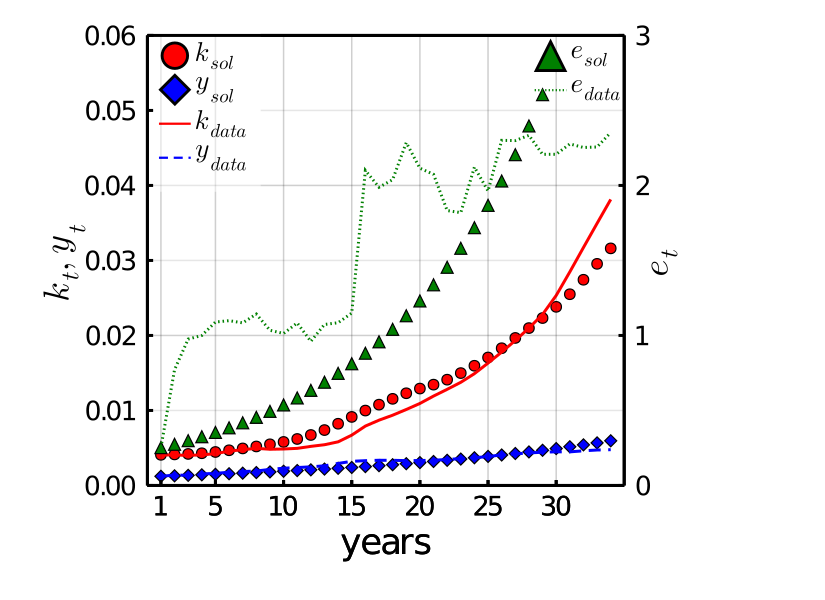

In [15]:
 function plot_graph(nnpred,country,nntstepsfull,kdata,ydata,edata)
    upscale = 0.5 #1 #8x upscaling in resolution
    fntsm = Plots.font("sans-serif", pointsize=round(12.0*upscale))
    fntlg = Plots.font("sans-serif", pointsize=round(16.0*upscale))
    default(titlefont=fntlg, guidefont=fntlg, tickfont=fntsm, legendfont=fntsm)
    default(size=(550*upscale,400*upscale)) #Plot canvas size
    default(dpi=300)
    
#     fctime = collect(Int(floor(size(nntstepsfull,1)*0.8))+1:1:size(nntstepsfull,1)) 
# #             println(fctime)
#             println(nntstepsfull)
    plotkyenn12ic= Plots.scatter(xaxis=nntstepsfull,nnpred[1:2,:]',
        label=[L"k_{sol}" L"y_{sol}"],color=[:red :blue],legend=(0.102,0.955),
        markershape=[:circle :diamond],markersize=4*upscale,
        ylabel=L"k_t,y_t",right_margin = 15Plots.mm)
            
    plot!(plotkyenn12ic,[kdata,ydata],label=[L"k_{data}" L"y_{data}"],linestyle=[:solid :dash],
        color=[:red :blue],ylim=(0,1.5.*round(maximum(kdata);sigdigits=1)),foreground_color_legend = nothing)

#     scatter!(plotkyenn12ic,nntstepsfull,nnpred[1:2,:]',
#         color=[:red :blue],markershape=[:circle :diamond], markersize=4,label=nothing)

    pr = twinx()
    
#     scatter!(pr,nntstepsfull,nnpred[3,:],
#         color=:green,legend=(0.89,0.954), markershape = [:utriangle], markersize=4, label=nothing)

    Plots.scatter!(pr,nntstepsfull,nnpred[3,:],
        label=L"e_{sol}",color=:green,legend=(0.89,0.954), markershape = [:utriangle], markersize=4*upscale,
        ylabel=L"e_t",right_margin = 15Plots.mm,
        foreground_color_legend = nothing,background_color_legend = nothing)
            
    plot!(pr,edata,label=L"e_{data}",color=:green,ylim=(0,1.5.*round(maximum(edata);sigdigits=1)),
                linestyle=:dot)
    
 xpts = collect(0:5:5*ceil(length(nntstepsfull)/5))
#     if xpts[end] != length(nntsteps)
#         push!(xpts,length(nntsteps))
        xpts[1]=1
#     end
    
   plot(plotkyenn12ic,xlabel = "years",xticks=xpts,box=:on,linewidth=2*upscale)
#     display(StatsPlots.plot(pl,xlabel = "Days post 21 March 2020",xticks=0:10:110,tickfont=12,
#         guidefont = 16,legendfontsize=12,legend=(0.1,0.92),
#         dpi=300,box=:on,linewidth=2*upscale))

#     savefig(string(country,"model3_v1_190621"))
end

plot_graph(pred,country,nntsteps,kdata,ydata,edata)

# Calculating errors

In [16]:
# Calculating errors for k_t, y_t, e_t

Botswana_k_pred = convert(Array{Float64},best_model[1,:])
Botswana_y_pred = convert(Array{Float64},best_model[2,:])
Botswana_e_pred = convert(Array{Float64},best_model[3,:])

#checking the implementation of MSE
# println("(Botswana Mean Squared Errors) kt: ", Flux.mse(Botswana_k_pred, kdata), 
#     " yt: ", Flux.mse(Botswana_y_pred, ydata), 
#     " et: ", Flux.mse(Botswana_e_pred, edata))
println("(Botswana Mean Squared Errors) kt: ", (sqL2dist(Botswana_k_pred, identity.(kdata))/length(kdata)), 
    " yt: ", (sqL2dist(Botswana_y_pred, identity.(ydata))/length(ydata)), 
    " et: ", (sqL2dist(Botswana_e_pred, identity.(edata))/length(edata)))
println("(Botswana Root Mean Squared Errors) kt: ", (L2dist(Botswana_k_pred, identity.(kdata))/length(kdata)), 
    " yt: ", (L2dist(Botswana_y_pred, identity.(ydata))/length(ydata)), 
    " et: ", (L2dist(Botswana_e_pred, identity.(edata))/length(edata)))
#checking the implementation of MAE
# println("(Botswana Mean Absolute Errors) kt: ", Flux.mae(Botswana_k_pred, kdata), 
#     " yt: ", Flux.mae(Botswana_y_pred, ydata), 
#     " et: ", Flux.mae(Botswana_e_pred, edata))
println("(Botswana Mean Absolute Errors) kt: ", 
    L1dist(convert(Array{Float64},Botswana_k_pred),identity.(kdata))/length(kdata), 
    " yt: ", L1dist(convert(Array{Float64},Botswana_y_pred),identity.(ydata))/length(ydata), 
    " et: ", L1dist(convert(Array{Float64},Botswana_e_pred),identity.(edata))/length(edata))


function r2_impl(data,pred)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
return r2  
end
#checking the implementation of R2
# println("(Botswana R2 Correlation Coefficient) yt: ", r2(ols_y_Botswana),
#     " et: ", r2(ols_e_Botswana))
# println("(Botswana R2 Correlation Coefficient) yt: ", r2_impl(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana)),
#     " et: ", r2_impl(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana)))
println("(Botswana R2 Correlation Coefficient) kt: ", r2_impl(kdata, Botswana_k_pred), 
    " yt: ", r2_impl(ydata, Botswana_y_pred), 
    " et: ", r2_impl(edata, Botswana_e_pred))

function Ar2_impl(data,pred, p)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
n = size(data)[1]
# ar2 = 1 - (1 - r2)*(n-1)/(n-p-1)
ar2 = 1 - (1 - r2)*(n-1)/(n-p) 
# using this formula means that the intercept is also counted as a parameter
# this formula requires we be explicit about all parameters
return ar2  
end

#checking the implementation of adjusted R2
# println("(Botswana Adjusted R2) yt: ", adjr2(ols_y_Botswana),
#     " et: ", adjr2(ols_e_Botswana))
# println("(Botswana Adjusted R2) yt: ", Ar2_impl(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),2),
#     " et: ", Ar2_impl(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),2))
# for regular regression:
# 3 parameters are coeff of lge, coeff of t, y intercept 
# for k, there are 5 parameters including intercept
# there are 4 parameters here that are adjusted
println("(Botswana Adjusted R2) kt: ", Ar2_impl(kdata, Botswana_k_pred, 4), 
    " yt: ", Ar2_impl(ydata, Botswana_y_pred, 4), 
    " et: ", Ar2_impl(edata, Botswana_e_pred, 4))

println("(Botswana Mean Percentage Error) kt: ", mean((kdata.- Botswana_k_pred)./kdata)*100,
    " yt: ", mean((ydata.- Botswana_y_pred)./ydata)*100,
    " et: ", mean((edata.- Botswana_e_pred)./edata)*100)

println("(Botswana Mean Absolute Percentage Error) kt: ", mean(abs.((kdata.- Botswana_k_pred)./kdata))*100,
    " yt: ", mean(abs.((ydata.- Botswana_y_pred)./ydata))*100,
    " et: ", mean(abs.((edata.- Botswana_e_pred)./edata))*100)

println("(Botswana Mean Arctangent Absolute Percentage Error) kt: ", mean(atan.(abs.((kdata.- Botswana_k_pred)./kdata)))*100,
    " yt: ", mean(atan.(abs.((ydata.- Botswana_y_pred)./ydata)))*100,
    " et: ", mean(atan.(abs.((edata.- Botswana_e_pred)./edata)))*100)

println("(Botswana Mean Bias Error) kt: ", mean(kdata.- Botswana_k_pred),
    " yt: ", mean(ydata.- Botswana_y_pred),
    " et: ", mean(edata.- Botswana_e_pred))

function loglikelihood_calc(data,pred)
rss = sum((data .-pred).^2)
n = length(pred)
return -n/2*(log(2pi*rss/n)+1)
end
# implementation from julia: https://github.com/JuliaStats/GLM.jl/blob/950579166c52ff1cbbeab75cbc23235b30640802/src/lm.jl

#checking implementation for loglikelihood
# println("(Botswana Loglikelihood) yt: ", loglikelihood(ols_y_Botswana),
#     " et: ", loglikelihood(ols_e_Botswana))
# println("(Botswana Loglikelihood) yt: ", loglikelihood_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana)),
#     " et: ", loglikelihood_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana)))
println("(Botswana Loglikelihood) kt: ", loglikelihood_calc(kdata, Botswana_k_pred),
    " yt: ", loglikelihood_calc(ydata, Botswana_y_pred),
    " et: ", loglikelihood_calc(edata, Botswana_e_pred))

function aic_calc(data, pred, params)
    L = loglikelihood_calc(data,pred)
    return 2*params-2*L
end

#checking implementation for aic
# println("(Botswana Aikaike Information Criterion) yt: ", aic(ols_y_Botswana),
#     " et: ", aic(ols_e_Botswana))
# println("(Botswana Aikaike Information Criterion) yt: ", aic_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", aic_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana Aikaike Information Criterion) kt: ", aic_calc(kdata, Botswana_k_pred, 5),
    " yt: ", aic_calc(ydata, Botswana_y_pred, 5),
    " et: ", aic_calc(edata, Botswana_e_pred, 5))

function aicc_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + 2*params + 2*params*(params+1)/(n-params-1)
end

# checking implementation for aicc
# println("(Botswana Corrected AIC) yt: ", aicc(ols_y_Botswana),
#     " et: ", aicc(ols_e_Botswana))
# println("(Botswana Corrected AIC) yt: ", aicc_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", aicc_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana Corrected AIC) kt: ", aicc_calc(kdata, Botswana_k_pred, 5),
    " yt: ", aicc_calc(ydata, Botswana_y_pred, 5),
    " et: ", aicc_calc(edata, Botswana_e_pred, 5))

function bic_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + params*log(n)
end

# checking implementation for bic_calc
# println("(Botswana Corrected BIC) yt: ", bic(ols_y_Botswana),
#     " et: ", bic(ols_e_Botswana))
# println("(Botswana Corrected BIC) yt: ", bic_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", bic_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana BIC) kt: ", bic_calc(kdata, Botswana_k_pred, 5),
    " yt: ", bic_calc(ydata, Botswana_y_pred, 5),
    " et: ", bic_calc(edata, Botswana_e_pred, 5))



(Botswana Mean Squared Errors) kt: 4.47216673935207e-6 yt: 2.2093715188566083e-7 et: 0.5250770381519745
(Botswana Root Mean Squared Errors) kt: 0.00036267659955295734 yt: 8.061111291905633e-5 et: 0.1242716472031633
(Botswana Mean Absolute Errors) kt: 0.0014929360619728614 yt: 0.0003559367954803302 et: 0.6177372752224081
(Botswana R2 Correlation Coefficient) kt: 0.9519872021639394 yt: 0.8136127116304874 et: -0.430603116307656
(Botswana Adjusted R2) kt: 0.9471859223803333 yt: 0.7949739827935361 et: -0.5736634279384216
(Botswana Mean Percentage Error) kt: -9.571969875515135 yt: 5.424071906245571 et: 24.409463660002874
(Botswana Mean Absolute Percentage Error) kt: 13.37713401907055 yt: 11.17407241240175 et: 39.78140083851696
(Botswana Mean Arctangent Absolute Percentage Error) kt: 13.106851794032856 yt: 11.058614277420169 et: 36.62598721233305
(Botswana Mean Bias Error) kt: -0.0002456185441186038 yt: 9.060430581363687e-5 et: 0.2679275520259036
(Botswana Loglikelihood) kt: 161.1559280105894

In [17]:
# Calculating errors for differentials

kdata = identity.(kdata[2:end-1].-kdata[1:end-2])
Botswana_k_pred = Botswana_k_pred[2:end-1].-Botswana_k_pred[1:end-2]
Botswana_y_pred = Botswana_y_pred[2:end-1].-Botswana_y_pred[1:end-2]
ydata = identity.(ydata[2:end-1].-ydata[1:end-2])
Botswana_e_pred = Botswana_e_pred[2:end-1].-Botswana_e_pred[1:end-2]
edata = identity.(edata[2:end-1].-edata[1:end-2])


#checking the implementation of MSE
# println("(Botswana Mean Squared Errors) kt: ", Flux.mse(Botswana_k_pred, kdata), 
#     " yt: ", Flux.mse(Botswana_y_pred, ydata), 
#     " et: ", Flux.mse(Botswana_e_pred, edata))
println("(Botswana Mean Squared Errors) kt: ", (sqL2dist(Botswana_k_pred, identity.(kdata))/length(kdata)), 
    " yt: ", (sqL2dist(Botswana_y_pred, identity.(ydata))/length(ydata)), 
    " et: ", (sqL2dist(Botswana_e_pred, identity.(edata))/length(edata)))
println("(Botswana Root Mean Squared Errors) kt: ", (L2dist(Botswana_k_pred, identity.(kdata))/length(kdata)), 
    " yt: ", (L2dist(Botswana_y_pred, identity.(ydata))/length(ydata)), 
    " et: ", (L2dist(Botswana_e_pred, identity.(edata))/length(edata)))
#checking the implementation of MAE
# println("(Botswana Mean Absolute Errors) kt: ", Flux.mae(Botswana_k_pred, kdata), 
#     " yt: ", Flux.mae(Botswana_y_pred, ydata), 
#     " et: ", Flux.mae(Botswana_e_pred, edata))
println("(Botswana Mean Absolute Errors) kt: ", 
    L1dist(convert(Array{Float64},Botswana_k_pred),identity.(kdata))/length(kdata), 
    " yt: ", L1dist(convert(Array{Float64},Botswana_y_pred),identity.(ydata))/length(ydata), 
    " et: ", L1dist(convert(Array{Float64},Botswana_e_pred),identity.(edata))/length(edata))


function r2_impl(data,pred)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
return r2  
end
#checking the implementation of R2
# println("(Botswana R2 Correlation Coefficient) yt: ", r2(ols_y_Botswana),
#     " et: ", r2(ols_e_Botswana))
# println("(Botswana R2 Correlation Coefficient) yt: ", r2_impl(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana)),
#     " et: ", r2_impl(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana)))
println("(Botswana R2 Correlation Coefficient) kt: ", r2_impl(kdata, Botswana_k_pred), 
    " yt: ", r2_impl(ydata, Botswana_y_pred), 
    " et: ", r2_impl(edata, Botswana_e_pred))

function Ar2_impl(data,pred, p)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
n = size(data)[1]
# ar2 = 1 - (1 - r2)*(n-1)/(n-p-1)
ar2 = 1 - (1 - r2)*(n-1)/(n-p) 
# using this formula means that the intercept is also counted as a parameter
# this formula requires we be explicit about all parameters
return ar2  
end

#checking the implementation of adjusted R2
# println("(Botswana Adjusted R2) yt: ", adjr2(ols_y_Botswana),
#     " et: ", adjr2(ols_e_Botswana))
# println("(Botswana Adjusted R2) yt: ", Ar2_impl(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),2),
#     " et: ", Ar2_impl(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),2))
# for regular regression:
# 3 parameters are coeff of lge, coeff of t, y intercept 
# for k, there are 5 parameters including intercept
# there are 4 parameters here that are adjusted
println("(Botswana Adjusted R2) kt: ", Ar2_impl(kdata, Botswana_k_pred, 4), 
    " yt: ", Ar2_impl(ydata, Botswana_y_pred, 4), 
    " et: ", Ar2_impl(edata, Botswana_e_pred, 4))

println("(Botswana Mean Percentage Error) kt: ", mean((kdata.- Botswana_k_pred)./kdata)*100,
    " yt: ", mean((ydata.- Botswana_y_pred)./ydata)*100,
    " et: ", mean((edata.- Botswana_e_pred)./edata)*100)

println("(Botswana Mean Absolute Percentage Error) kt: ", mean(abs.((kdata.- Botswana_k_pred)./kdata))*100,
    " yt: ", mean(abs.((ydata.- Botswana_y_pred)./ydata))*100,
    " et: ", mean(abs.((edata.- Botswana_e_pred)./edata))*100)

println("(Botswana Mean Arctangent Absolute Percentage Error) kt: ", mean(atan.(abs.((kdata.- Botswana_k_pred)./kdata)))*100,
    " yt: ", mean(atan.(abs.((ydata.- Botswana_y_pred)./ydata)))*100,
    " et: ", mean(atan.(abs.((edata.- Botswana_e_pred)./edata)))*100)

println("(Botswana Mean Bias Error) kt: ", mean(kdata.- Botswana_k_pred),
    " yt: ", mean(ydata.- Botswana_y_pred),
    " et: ", mean(edata.- Botswana_e_pred))

function loglikelihood_calc(data,pred)
rss = sum((data .-pred).^2)
n = length(pred)
return -n/2*(log(2pi*rss/n)+1)
end
# implementation from julia: https://github.com/JuliaStats/GLM.jl/blob/950579166c52ff1cbbeab75cbc23235b30640802/src/lm.jl

#checking implementation for loglikelihood
# println("(Botswana Loglikelihood) yt: ", loglikelihood(ols_y_Botswana),
#     " et: ", loglikelihood(ols_e_Botswana))
# println("(Botswana Loglikelihood) yt: ", loglikelihood_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana)),
#     " et: ", loglikelihood_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana)))
println("(Botswana Loglikelihood) kt: ", loglikelihood_calc(kdata, Botswana_k_pred),
    " yt: ", loglikelihood_calc(ydata, Botswana_y_pred),
    " et: ", loglikelihood_calc(edata, Botswana_e_pred))

function aic_calc(data, pred, params)
    L = loglikelihood_calc(data,pred)
    return 2*params-2*L
end

#checking implementation for aic
# println("(Botswana Aikaike Information Criterion) yt: ", aic(ols_y_Botswana),
#     " et: ", aic(ols_e_Botswana))
# println("(Botswana Aikaike Information Criterion) yt: ", aic_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", aic_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana Aikaike Information Criterion) kt: ", aic_calc(kdata, Botswana_k_pred, 5),
    " yt: ", aic_calc(ydata, Botswana_y_pred, 5),
    " et: ", aic_calc(edata, Botswana_e_pred, 5))

function aicc_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + 2*params + 2*params*(params+1)/(n-params-1)
end

# checking implementation for aicc
# println("(Botswana Corrected AIC) yt: ", aicc(ols_y_Botswana),
#     " et: ", aicc(ols_e_Botswana))
# println("(Botswana Corrected AIC) yt: ", aicc_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", aicc_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana Corrected AIC) kt: ", aicc_calc(kdata, Botswana_k_pred, 5),
    " yt: ", aicc_calc(ydata, Botswana_y_pred, 5),
    " et: ", aicc_calc(edata, Botswana_e_pred, 5))

function bic_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + params*log(n)
end

# checking implementation for bic_calc
# println("(Botswana Corrected BIC) yt: ", bic(ols_y_Botswana),
#     " et: ", bic(ols_e_Botswana))
# println("(Botswana Corrected BIC) yt: ", bic_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", bic_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana BIC) kt: ", bic_calc(kdata, Botswana_k_pred, 5),
    " yt: ", bic_calc(ydata, Botswana_y_pred, 5),
    " et: ", bic_calc(edata, Botswana_e_pred, 5))


(Botswana Mean Squared Errors) kt: 2.503448743546548e-7 yt: 1.2155037878746875e-8 et: 0.062460442859460945
(Botswana Root Mean Squared Errors) kt: 8.844929238599347e-5 yt: 1.9489610917379543e-5 et: 0.04418018604938366
(Botswana Mean Absolute Errors) kt: 0.0003341505120158662 yt: 9.087019820930439e-5 et: 0.18186494909092088
(Botswana R2 Correlation Coefficient) kt: 0.7242295457768976 yt: -0.8598484729561846 et: -0.2718421988355093
(Botswana Adjusted R2) kt: 0.6946827113958509 yt: -1.0591179522014902 et: -0.4081110058535997
(Botswana Mean Percentage Error) kt: -12.861283860112918 yt: 123.05489638470716 et: -1068.9714889886943
(Botswana Mean Absolute Percentage Error) kt: 97.91387482154995 yt: 291.8672858941332 et: 2147.2633044231434
(Botswana Mean Arctangent Absolute Percentage Error) kt: 47.00836256357838 yt: 65.09010281598188 et: 93.57208571140075
(Botswana Mean Bias Error) kt: 0.00016870831638564845 yt: -2.9660503987688555e-5 et: -0.043019524616365906
(Botswana Loglikelihood) kt: 197.